# RSA analysis

In [1]:
!pip install rsatoolbox
!pip install pandas
!pip install bdpy sklearn

     |████████████████████████████████| 131 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 4.5 MB 4.0 MB/s eta 0:00:01     |█████████████                   | 1.8 MB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 11.2 MB 12.6 MB/s eta 0:00:01
     |████████████████████████████████| 24.7 MB 16.2 MB/s eta 0:00:01
     |████████████████████████████████| 306 kB 45.8 MB/s eta 0:00:01
     |████████████████████████████████| 39.8 MB 823 kB/s  eta 0:00:01    |█                               | 1.2 MB 12.5 MB/s eta 0:00:04
     |████████████████████████████████| 34.6 MB 12.4 MB/s eta 0:00:01
     |████████████████████████████████| 215 kB 48.3 MB/s eta 0:00:01
     |████████████████████████████████| 880 kB 44.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 64.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 48.8 MB/s eta 0:00:01
     |████████████████████████████████| 178 kB 39.3 MB/s eta 0:00:01
     |██████████████████████████████

In [23]:
def plot_rdm(rdm, comb):
    #plt.clim(0,1)
    fig, ax = plt.subplots()
    im = ax.imshow(rdm)
    
    ax.figure.colorbar(im)
    ax.set_title("RDM "+comb)
    fig.tight_layout()

In [22]:
import rsatoolbox
import pickle
import numpy as np
import tqdm
import os
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import sys
import json
from itertools import product
from time import time

import pandas as pd
from scipy import stats

#from slir import SparseLinearRegression
from sklearn.linear_model import LinearRegression 
import matplotlib.pyplot as plt

import bdpy
from bdpy.bdata import concat_dataset
from bdpy.ml import add_bias
from bdpy.preproc import select_top
from bdpy.stats import corrcoef
from bdpy.util import makedir_ifnot, get_refdata
from bdpy.dataform import append_dataframe
from bdpy.distcomp import DistComp

import god_config as config

from util import rdm,kendall_tau, pred_corr, select_x

In [6]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)


In [7]:
plt.rcParams["figure.figsize"] = (12,12)

### Load the img names for the manually filtered training set

In [8]:
filtered_training_image_names = []
for img_name in os.listdir("dataset/training_filtered/"):
    filtered_training_image_names.append(img_name)
filtered_training_image_names.sort()

### Mapping img names to labels

In [9]:
import csv
mappings = {}
with open('dataset/image_training_id.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for r in reader:
        mappings[r[1]] = r[0]

In [10]:
mapped_filtered_training_images = []
for img in filtered_training_image_names:
    mapped_filtered_training_images.append(mappings[img])

### Load model features

In [12]:
with open('train_features_resnest50d.pkl', 'rb') as pkl_f:
    loaded_feats = pickle.load(pkl_f)
print('models loaded:', loaded_feats.keys())
print('shape: ', loaded_feats['resnest50d']['n04401680_29505.JPEG'][3].flatten().shape)

models loaded: dict_keys(['resnest50d'])
shape:  (200704,)


# Resnet

In [8]:
rdms_resnet = {}
for stage in [0,1,2,3,4]:
    feat_matrix = []
    for img_name in filtered_training_image_names:
        feat_matrix.append(loaded_feats['resnet50'][img_name][stage].flatten())
    np_mat = np.asarray(feat_matrix)
    data = rsatoolbox.data.Dataset(np_mat)
    rdms_resnet[stage] = rsatoolbox.rdm.calc_rdm(data, method='correlation')

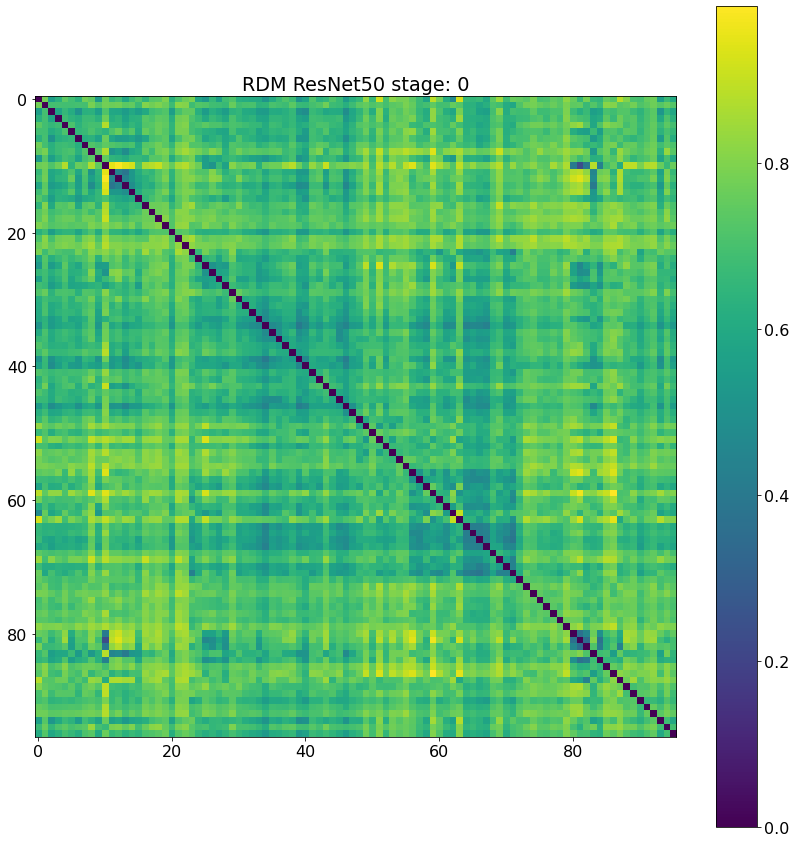

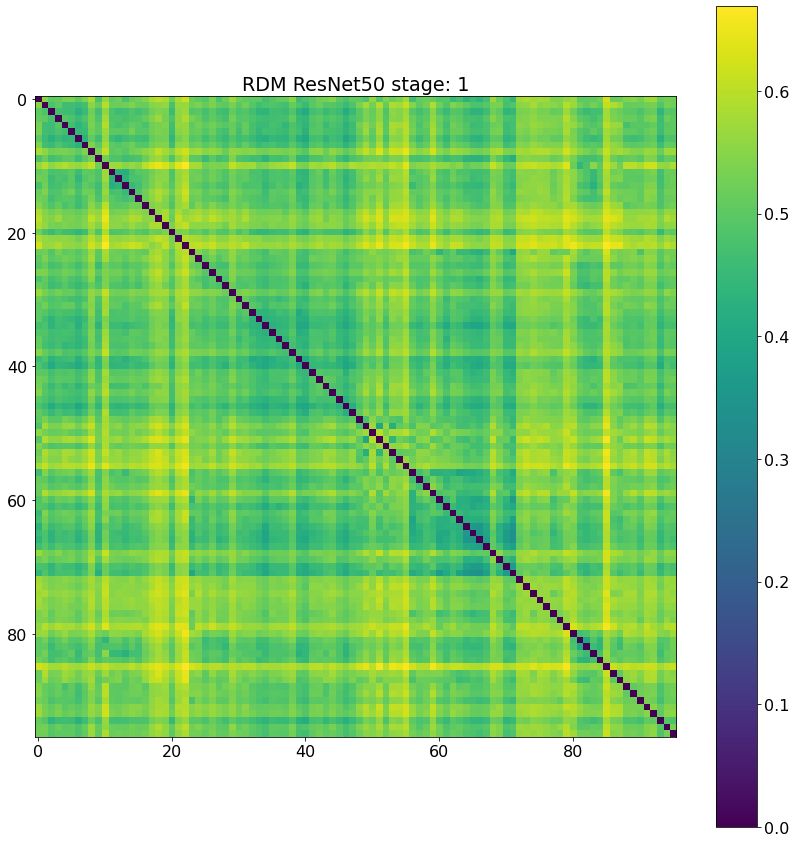

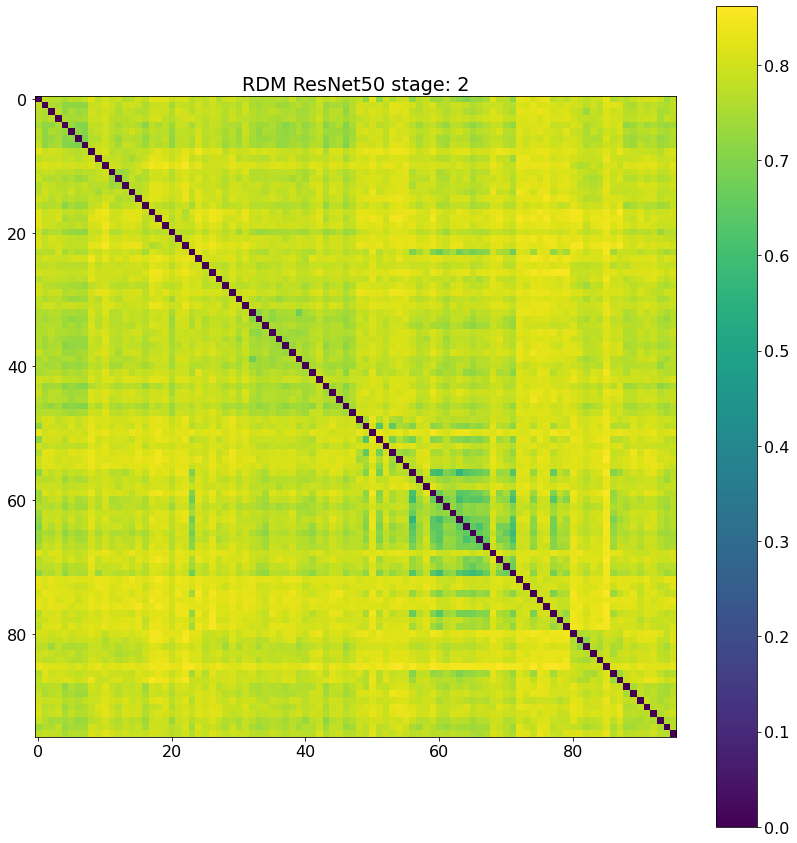

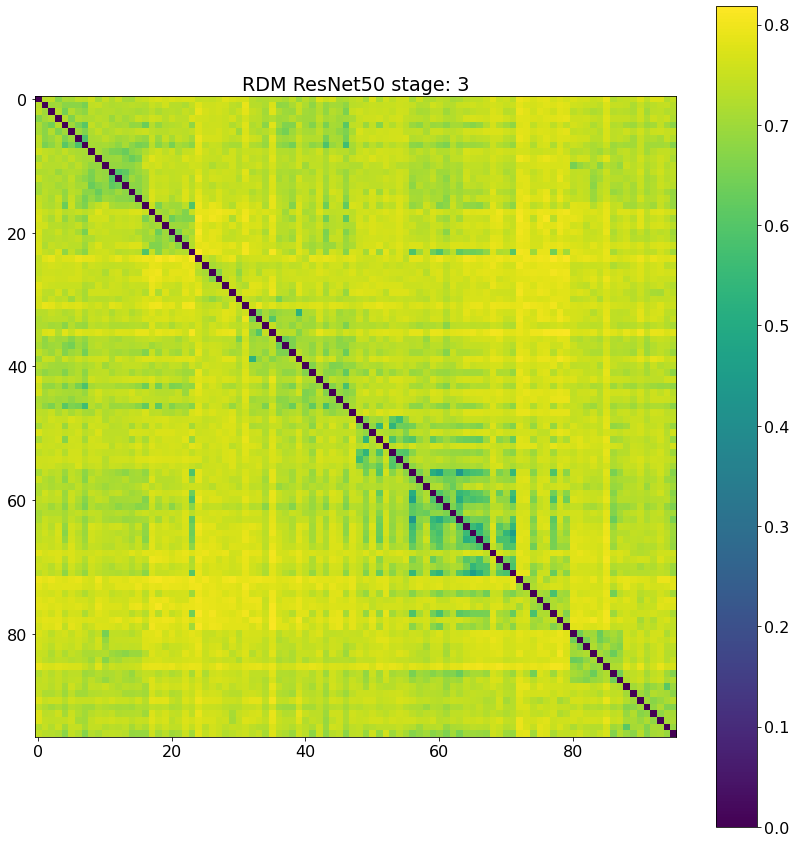

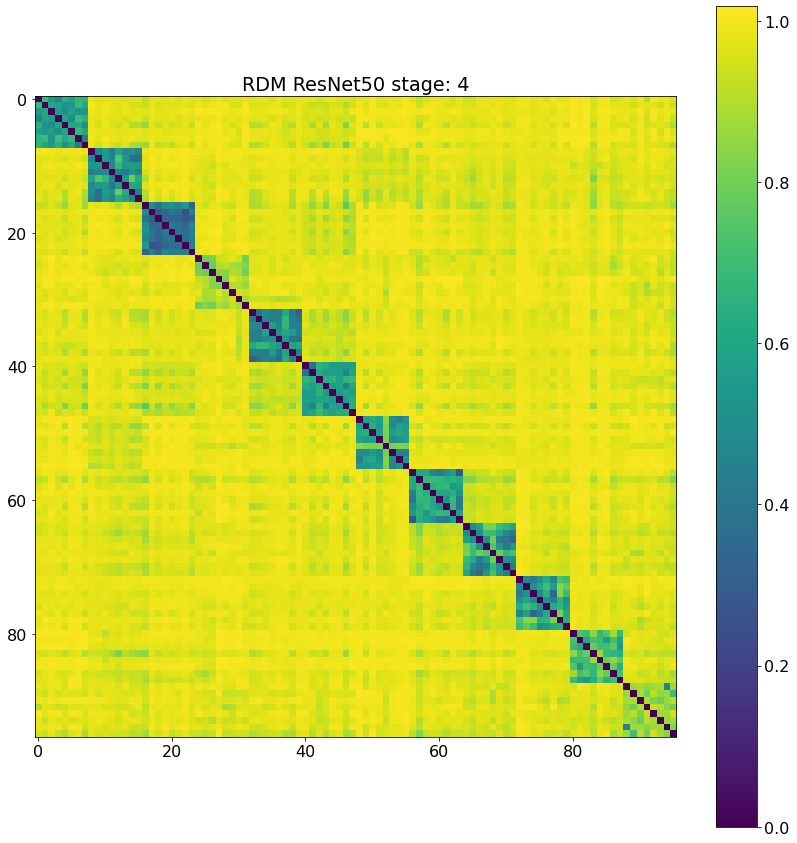

In [10]:
for stage in [0,1,2,3,4]:
    plot_rdm(rdms_resnet[stage].get_matrices().reshape(96,96), f'ResNet50 stage: {stage}')

# SE-Resnet

In [11]:
rdms_seresnet = {}
for stage in [0,1,2,3,4]:
    feat_matrix = []
    for img_name in filtered_training_image_names:
        feat_matrix.append(loaded_feats['seresnet50'][img_name][stage].flatten())
    np_mat = np.asarray(feat_matrix)
    data = rsatoolbox.data.Dataset(np_mat)
    rdms_seresnet[stage] = rsatoolbox.rdm.calc_rdm(data, method='correlation')

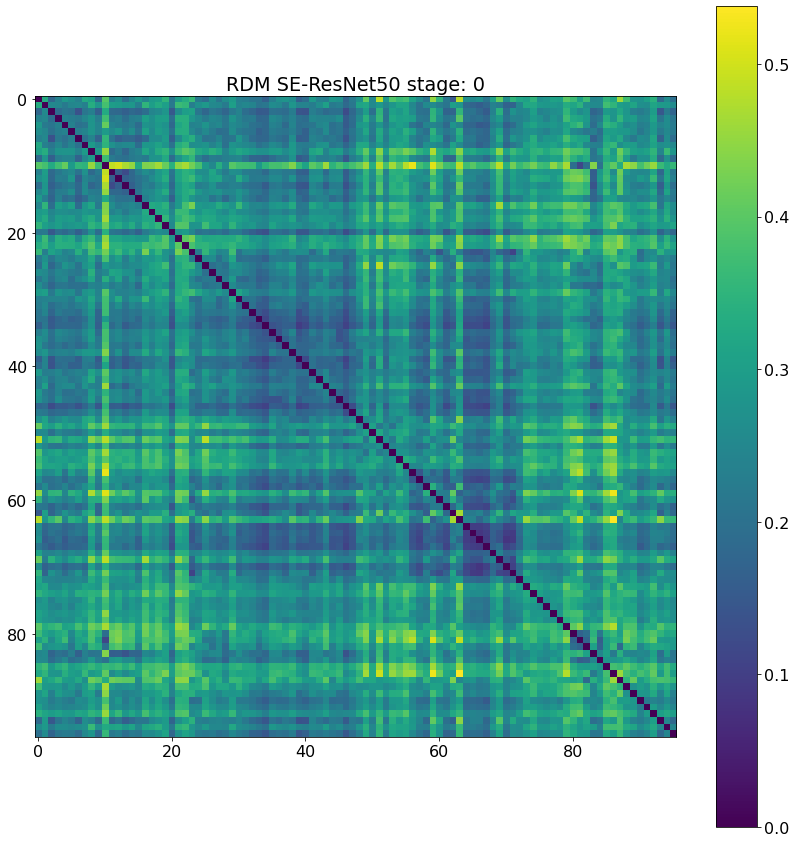

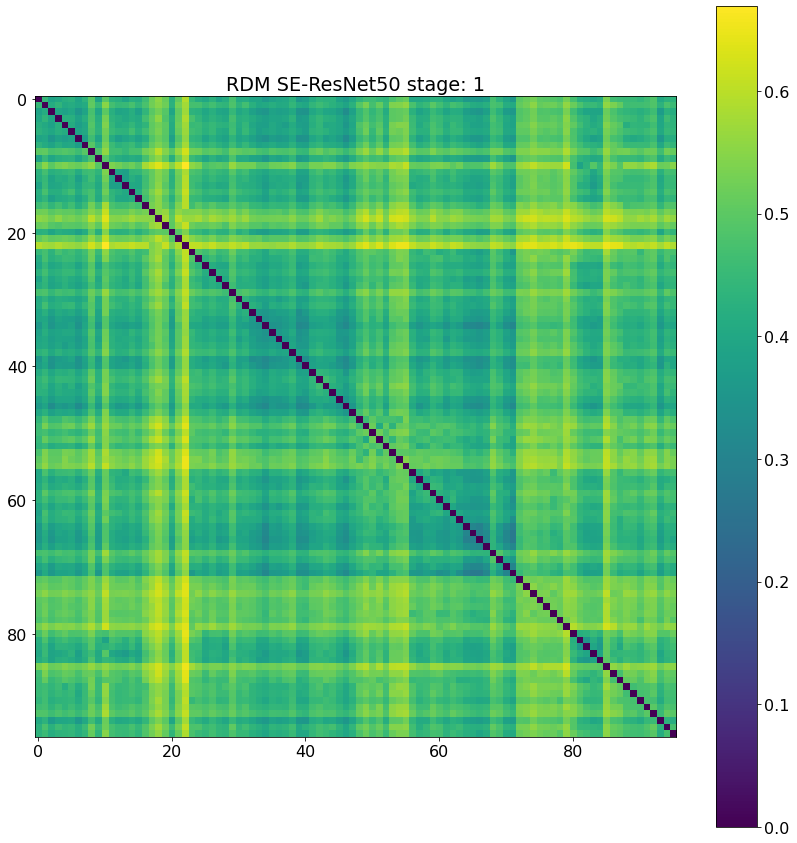

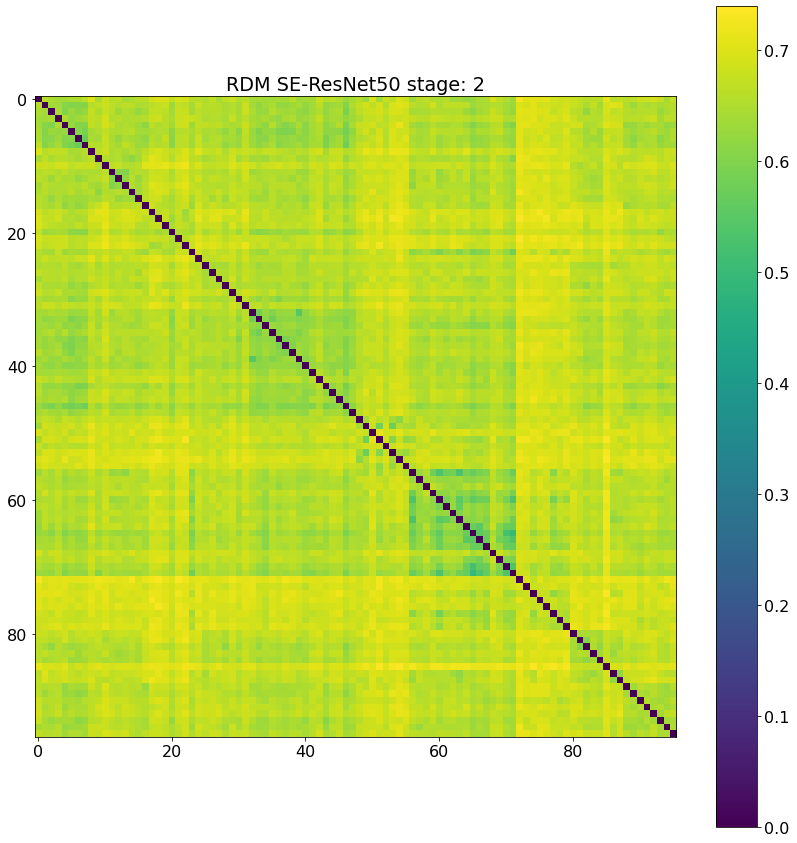

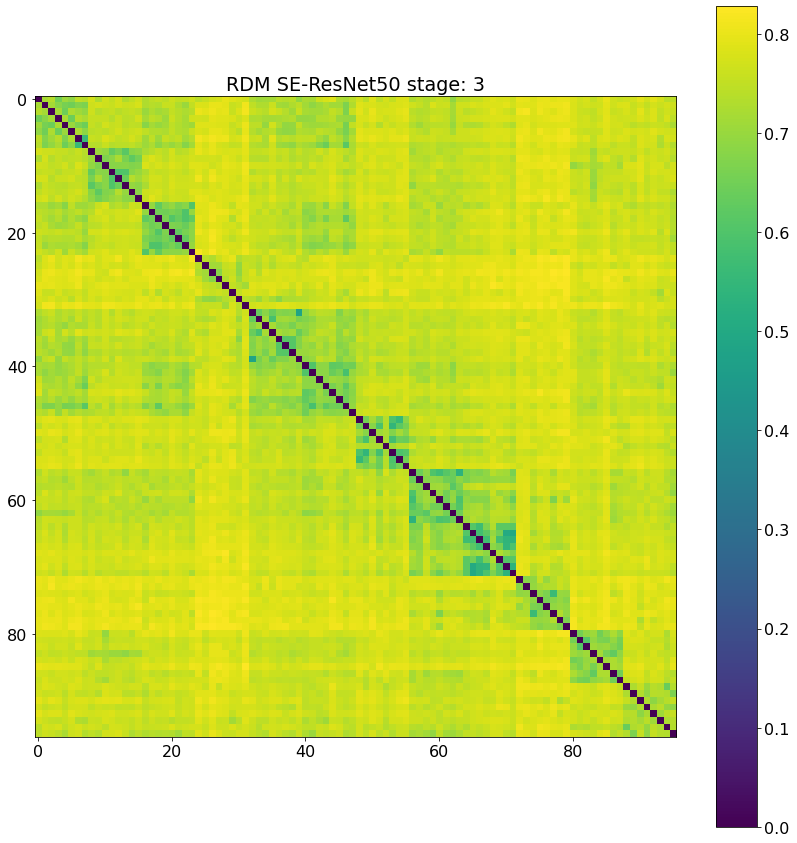

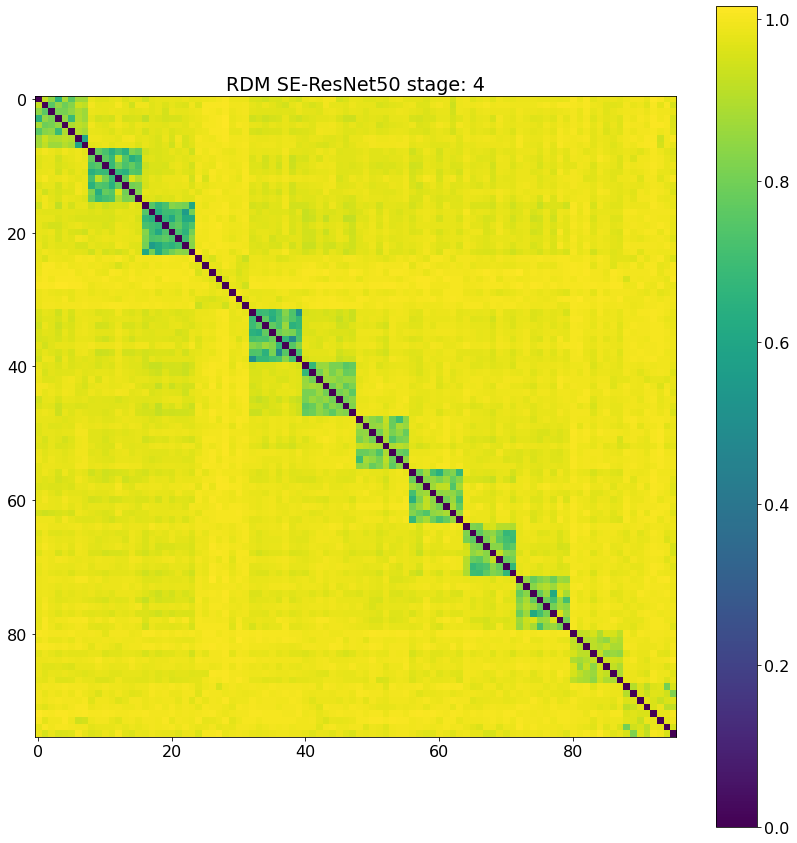

In [12]:
for stage in [0,1,2,3,4]:
    plot_rdm(rdms_seresnet[stage].get_matrices().reshape(96,96), f'SE-ResNet50 stage: {stage}')

# Resnest

In [13]:
rdms_resnest = {}
for stage in [0,1,2,3,4]:
    feat_matrix = []
    for img_name in filtered_training_image_names:
        feat_matrix.append(loaded_feats['resnest50d'][img_name][stage].flatten())
    np_mat = np.asarray(feat_matrix)
    data = rsatoolbox.data.Dataset(np_mat)
    rdms_resnest[stage] = rsatoolbox.rdm.calc_rdm(data, method='correlation')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


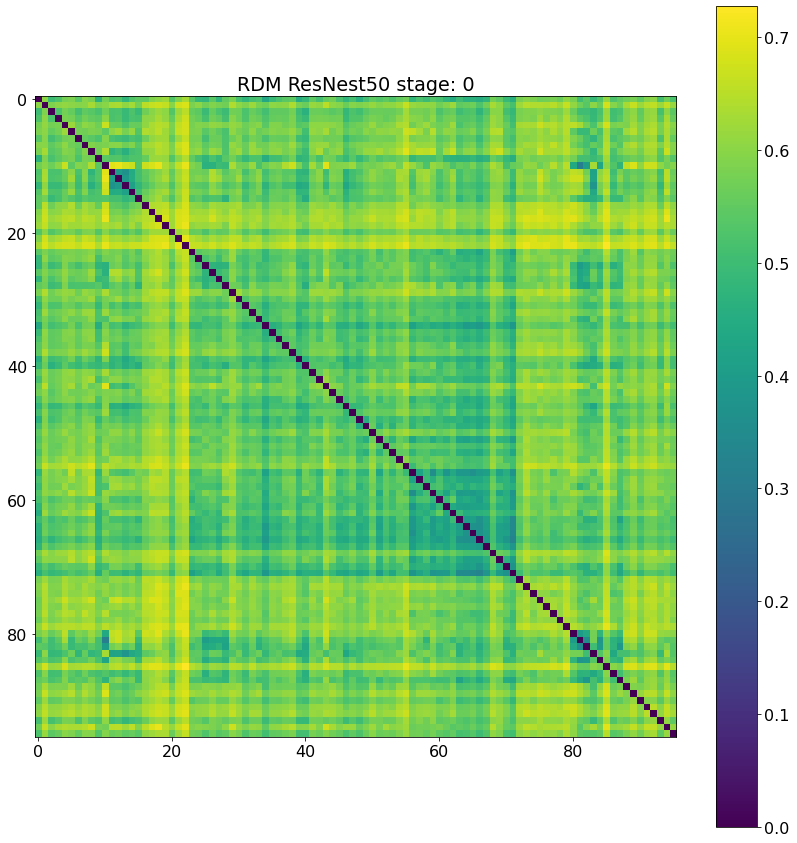

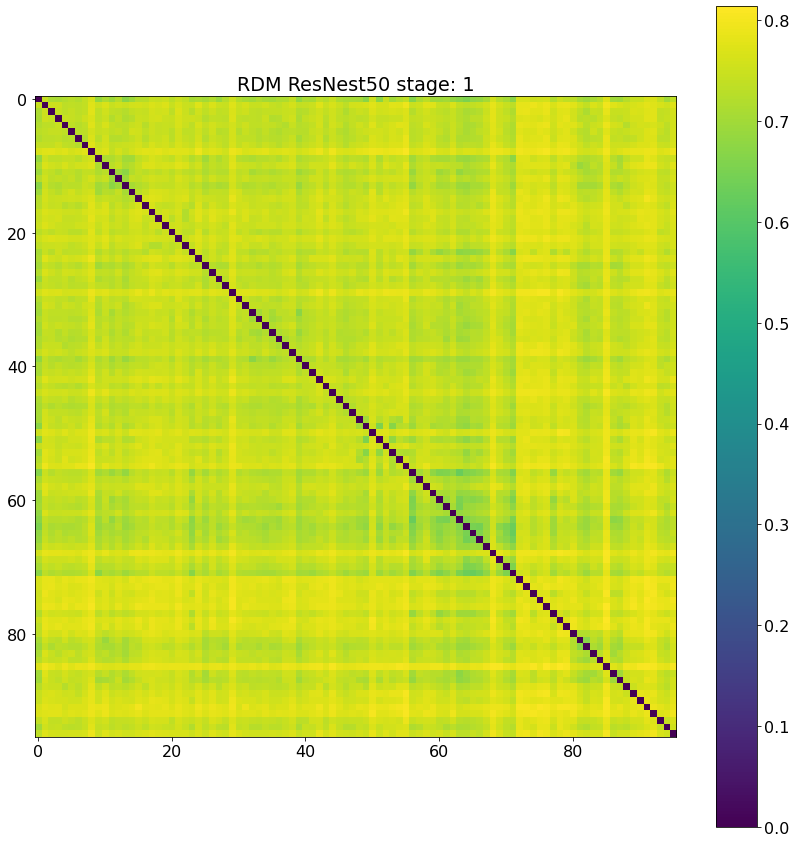

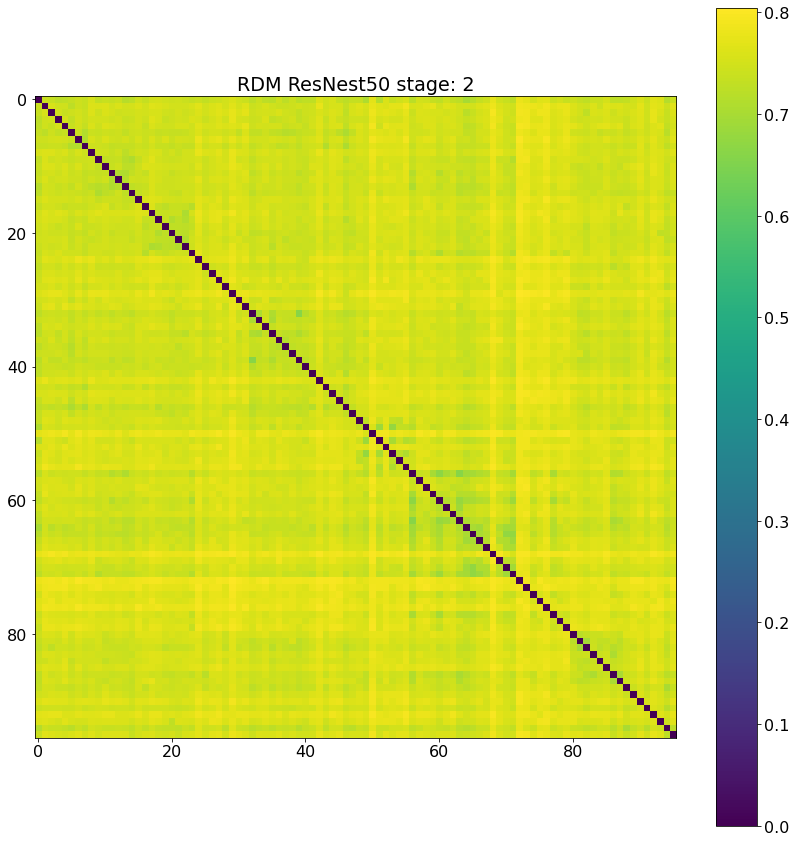

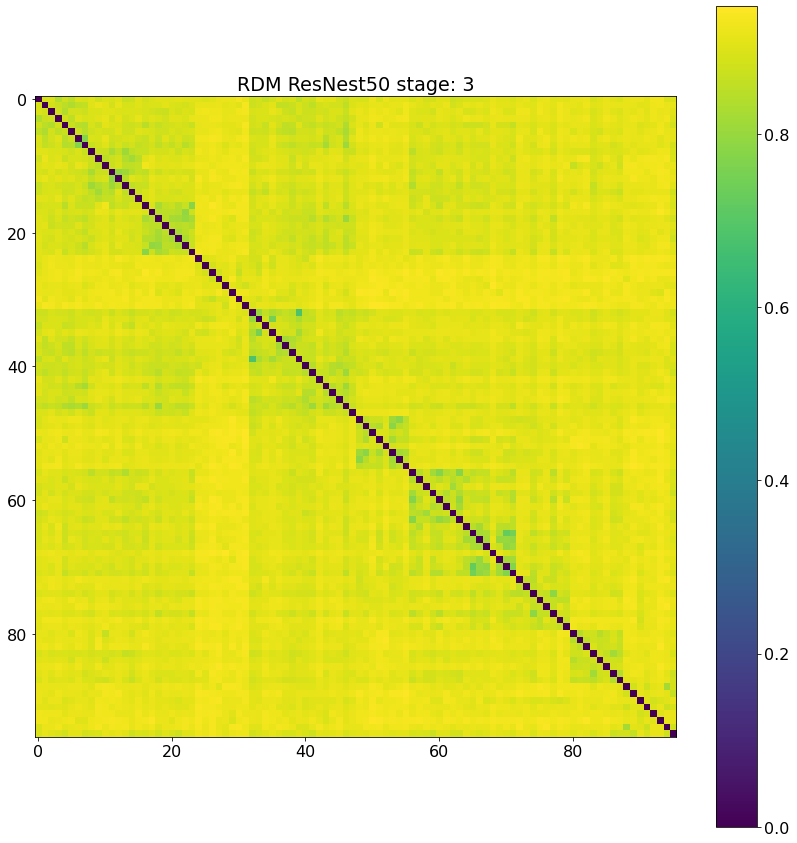

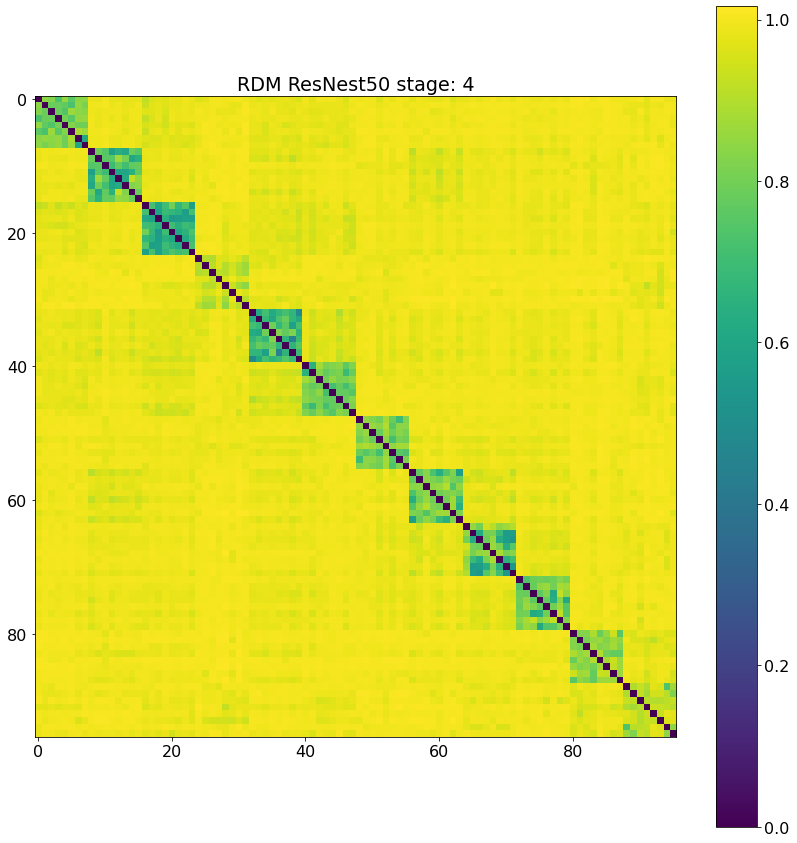

In [12]:
for stage in [0,1,2,3,4]:
    plot_rdm(rdms_resnest[stage].get_matrices().reshape(96,96), f'ResNest50 stage: {stage}')

## fMRI RDM

In [14]:
subjects = config.subjects
rois = config.rois
num_voxel = config.num_voxel

image_feature = config.image_feature_file
features = config.features

n_iter = 200

results_dir = config.results_dir

# Misc settings
#analysis_basename = os.path.basename(__file__)


### This is done subject by subject

In [36]:
fmri_data = bdpy.BData('dataset/Subject1.h5')

In [37]:
rois = {'V1' : 'ROI_V1 = 1',
        'V2' : 'ROI_V2 = 1',
        'V3' : 'ROI_V3 = 1',
        'V4' : 'ROI_V4 = 1',
        'LOC' : 'ROI_LOC = 1',
        'FFA' : 'ROI_FFA = 1',
        'PPA' : 'ROI_PPA = 1',
        'VC': 'ROI_VC = 1',
        'LVC': 'ROI_LVC = 1',
        'HVC': 'ROI_HVC = 1'}


In [38]:
fmri_data.select(rois['FFA']).shape

(3450, 928)

### Find the indices corresponding to the filtered training set. We want the orders to match

In [39]:
matched_indices = []
for label in mapped_filtered_training_images:
    found = False
    for idx, fmri_label in enumerate(fmri_data.select("stimulus_id")):
        if float(label) == fmri_label[0]:
            matched_indices.append(idx)
            found = True
            break
    if not found:
        print(label)


In [40]:
fmri_rdms = {}
for roi in rois:
    loaded_fmri_data = rsatoolbox.data.Dataset(fmri_data.select(rois[roi])[matched_indices])
    rdms_fmri = rsatoolbox.rdm.calc_rdm(loaded_fmri_data, method='correlation')
    fmri_rdms[roi] = rdms_fmri

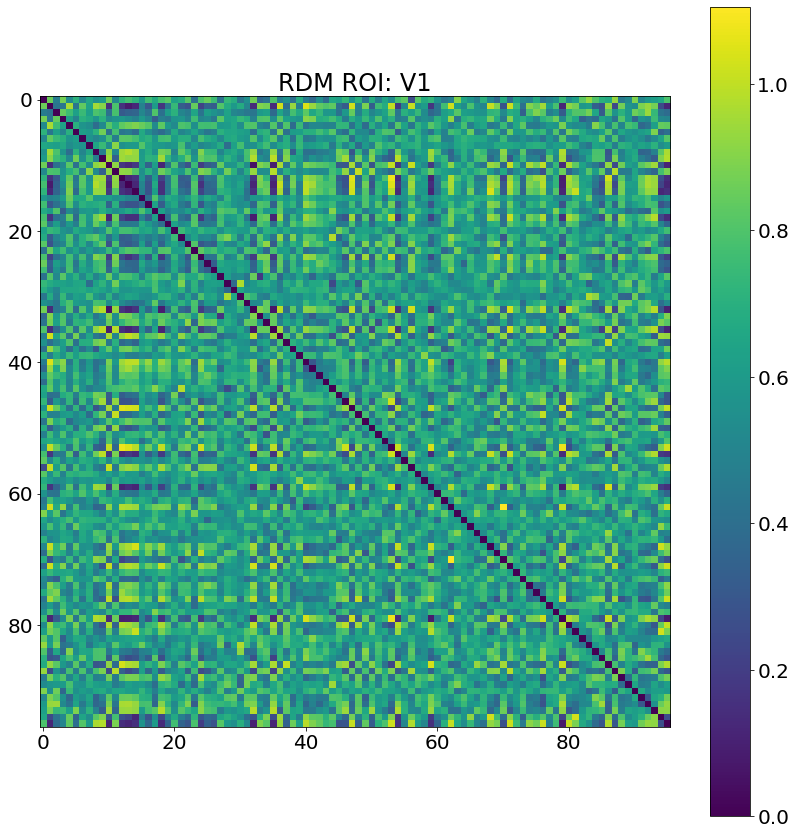

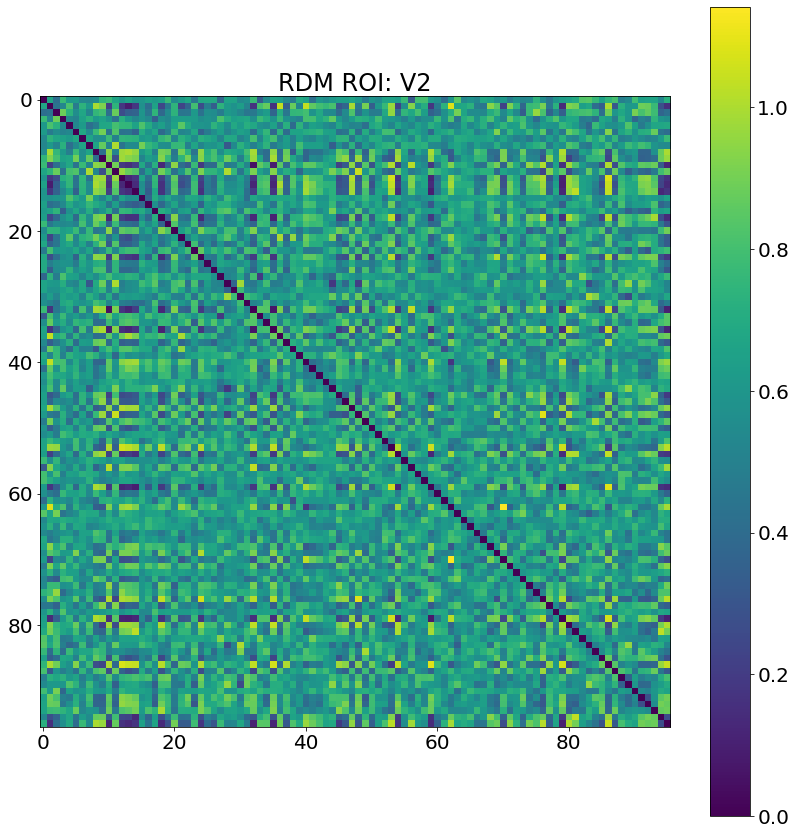

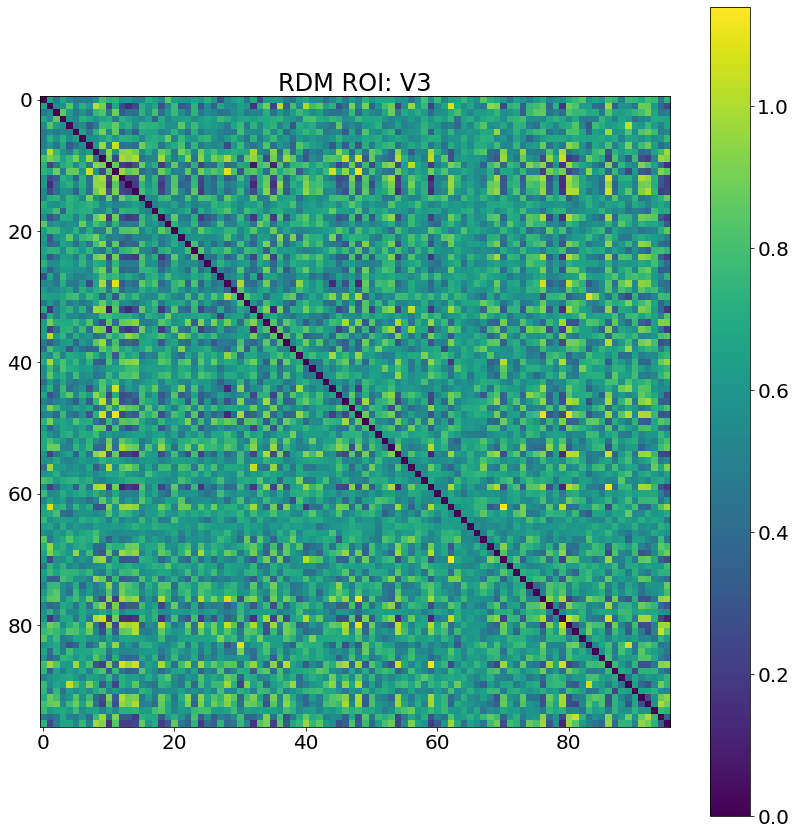

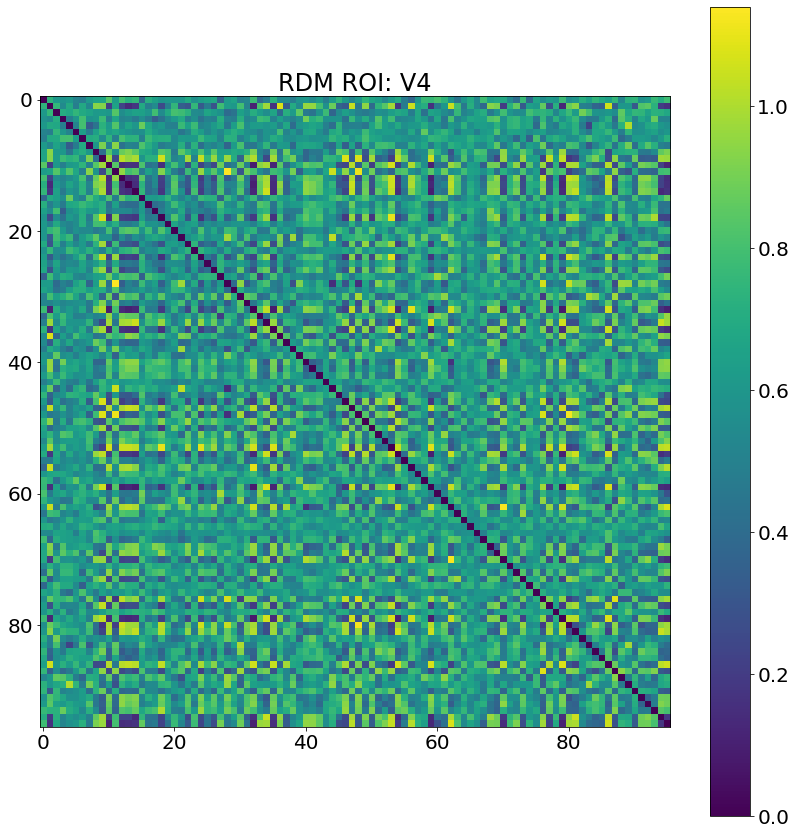

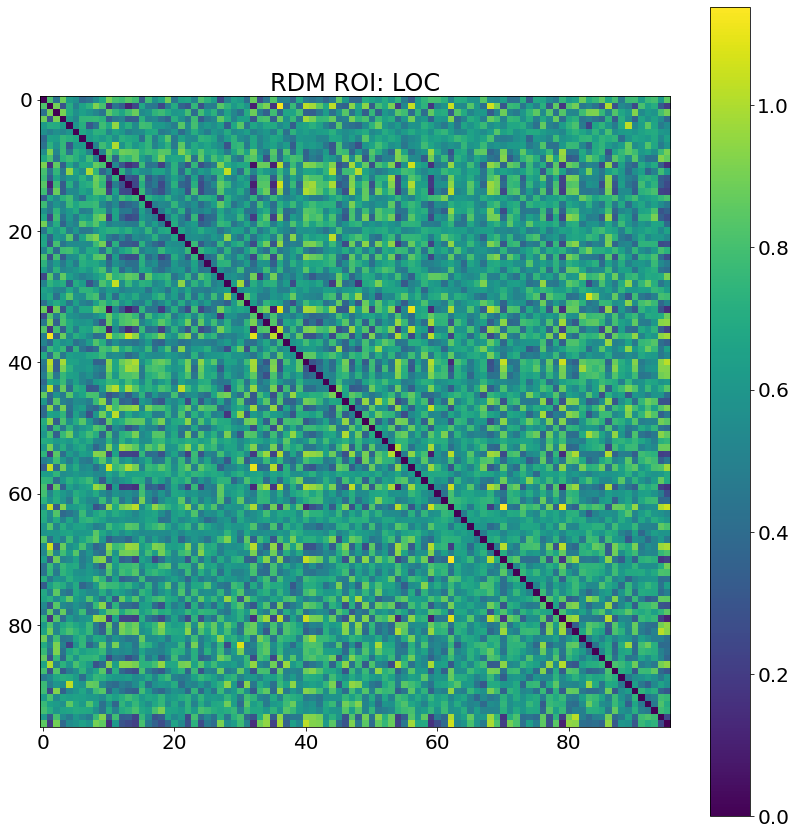

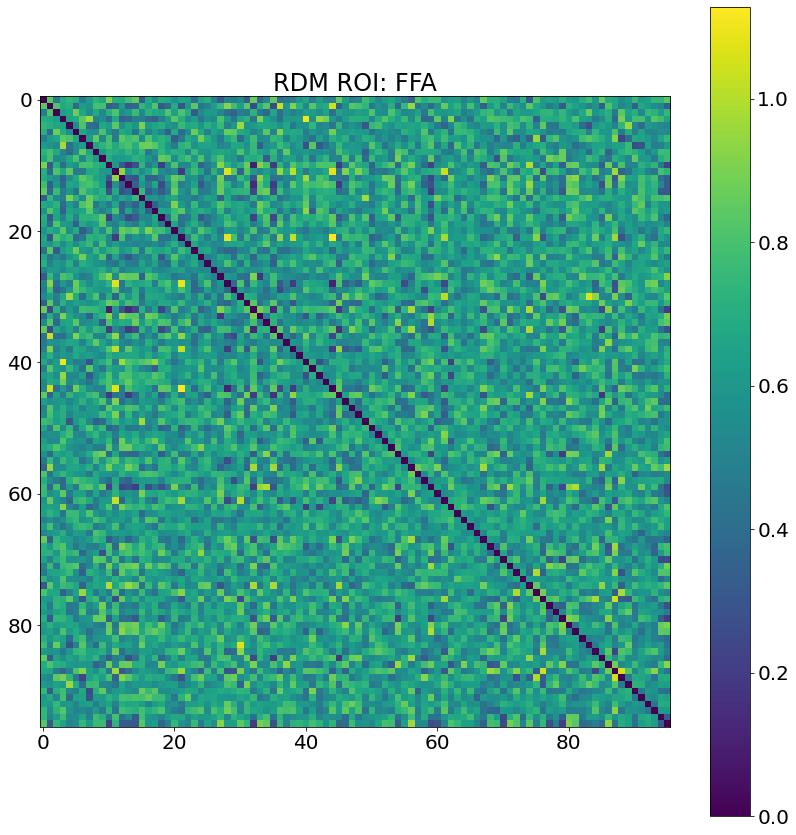

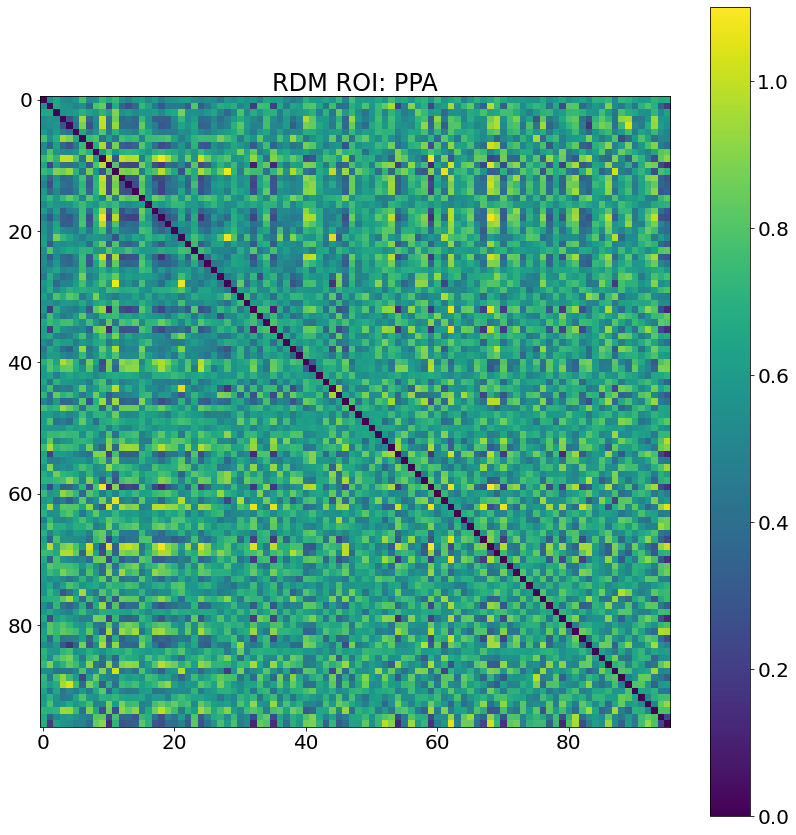

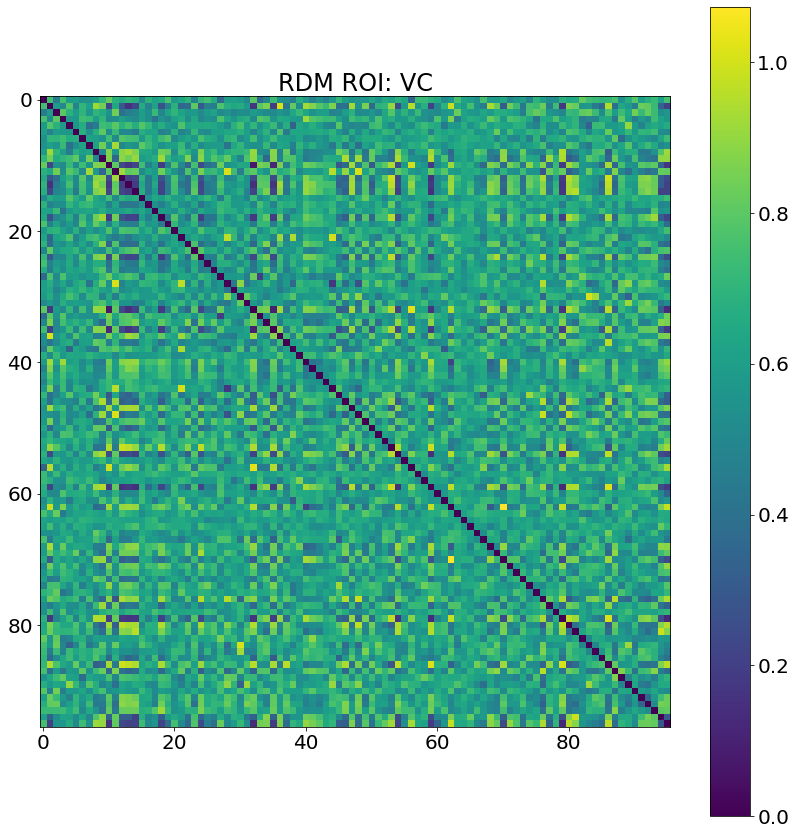

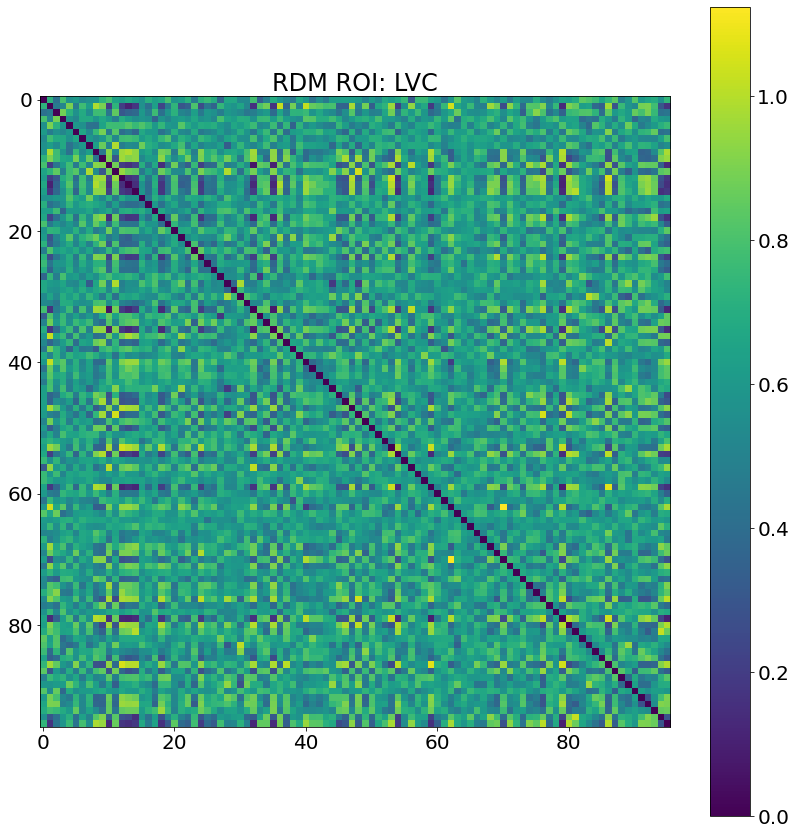

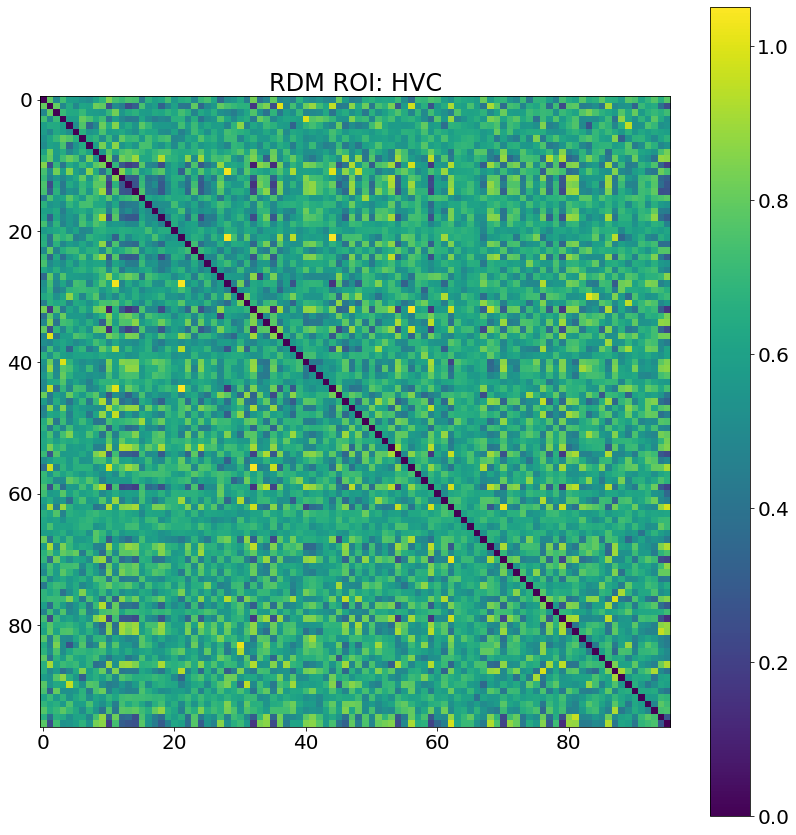

In [24]:
for roi in rois:
    plot_rdm(fmri_rdms[roi].get_matrices().reshape(96,96)/1.6, f'ROI: {roi}') #1.6 is to normalize for comparison

### Example for measuring kendall correlations

In [ ]:
for roi in rois:
    for stage in [0,1,2,3,4]:
        print(stage, roi)
        print(rsatoolbox.rdm.compare_kendall_tau(rdms_resnet[stage].get_matrices(), fmri_rdms[roi].get_matrices()))

### Just measuring all the tau correlations and saving them for later plotting

In [63]:
kendalls_sub2 = {}
kendalls_sub2['resnet50'] = {}
kendalls_sub2['seresnet50'] = {}
for roi in rois:
    kendalls_sub2['resnet50'][roi] = {}
    kendalls_sub2['seresnet50'][roi] = {}
    for stage in [0,1,2,3,4]:
        kendalls_sub2['resnet50'][roi][stage] = rsatoolbox.rdm.compare_kendall_tau(rdms_resnet[stage].get_matrices(), fmri_rdms[roi].get_matrices())
        kendalls_sub2['seresnet50'][roi][stage] = rsatoolbox.rdm.compare_kendall_tau(rdms_seresnet[stage].get_matrices(), fmri_rdms[roi].get_matrices())

In [54]:
kendalls_sub1 = {}
kendalls_sub1['resnet50'] = {}
kendalls_sub1['seresnet50'] = {}
for roi in rois:
    kendalls_sub1['resnet50'][roi] = {}
    kendalls_sub1['seresnet50'][roi] = {}
    for stage in [0,1,2,3,4]:
        kendalls_sub1['resnet50'][roi][stage] = rsatoolbox.rdm.compare_kendall_tau(rdms_resnet[stage].get_matrices(), fmri_rdms[roi].get_matrices())
        kendalls_sub1['seresnet50'][roi][stage] = rsatoolbox.rdm.compare_kendall_tau(rdms_seresnet[stage].get_matrices(), fmri_rdms[roi].get_matrices())

In [30]:
kendalls = {}
kendalls['resnet50'] = {}
kendalls['seresnet50'] = {}
for roi in rois:
    kendalls['resnet50'][roi] = {}
    kendalls['seresnet50'][roi] = {}
    for stage in [0,1,2,3,4]:
        kendalls['resnet50'][roi][stage] = rsatoolbox.rdm.compare_kendall_tau(rdms_resnet[stage].get_matrices(), fmri_rdms[roi].get_matrices())
        kendalls['seresnet50'][roi][stage] = rsatoolbox.rdm.compare_kendall_tau(rdms_seresnet[stage].get_matrices(), fmri_rdms[roi].get_matrices())

In [65]:
with open('resnet_seresnet_kendalls.pkl', 'wb') as pkl_f:
    pickle.dump([kendalls_sub1, kendalls_sub2, kendalls,], pkl_f, protocol=pickle.HIGHEST_PROTOCOL)

### Load the saved correlations to plot

In [26]:
with open('resnet_seresnet_kendalls.pkl', 'rb') as pkl_f:
    loaded_k = pickle.load(pkl_f)

In [41]:
# Adding the resnets correlations afterwards because its model features couldn't fit in memory
loaded_k[0]['resnest50'] = {}
for roi in rois:
    loaded_k[0]['resnest50'][roi] = {}
    for stage in [0,1,2,3,4]:
        loaded_k[0]['resnest50'][roi][stage] = rsatoolbox.rdm.compare_kendall_tau(rdms_resnest[stage].get_matrices(), fmri_rdms[roi].get_matrices())

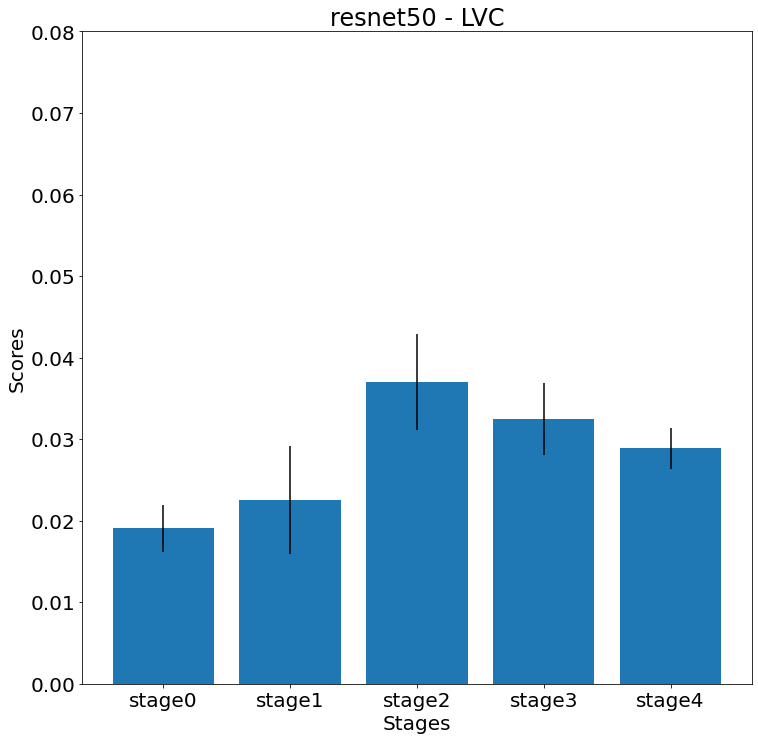

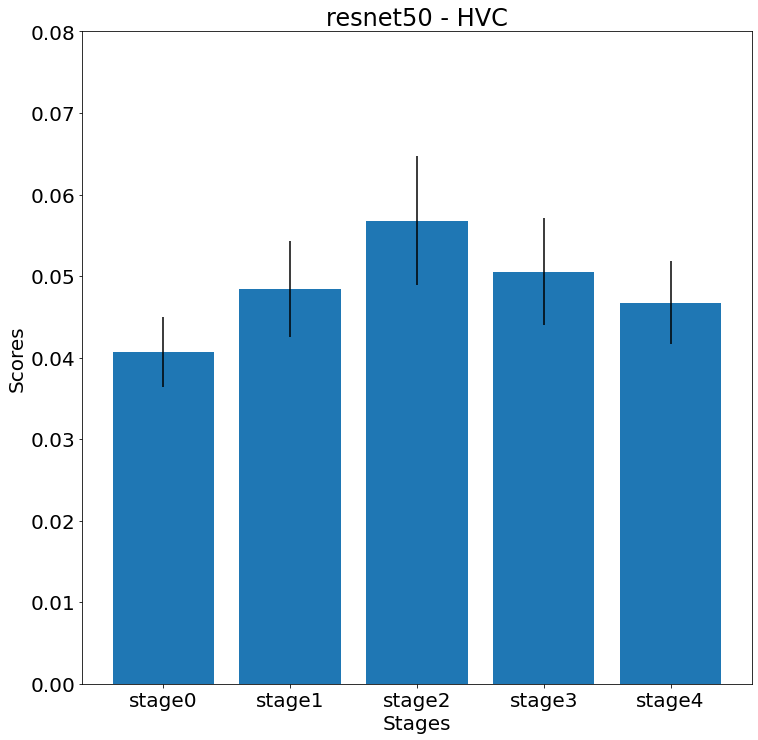

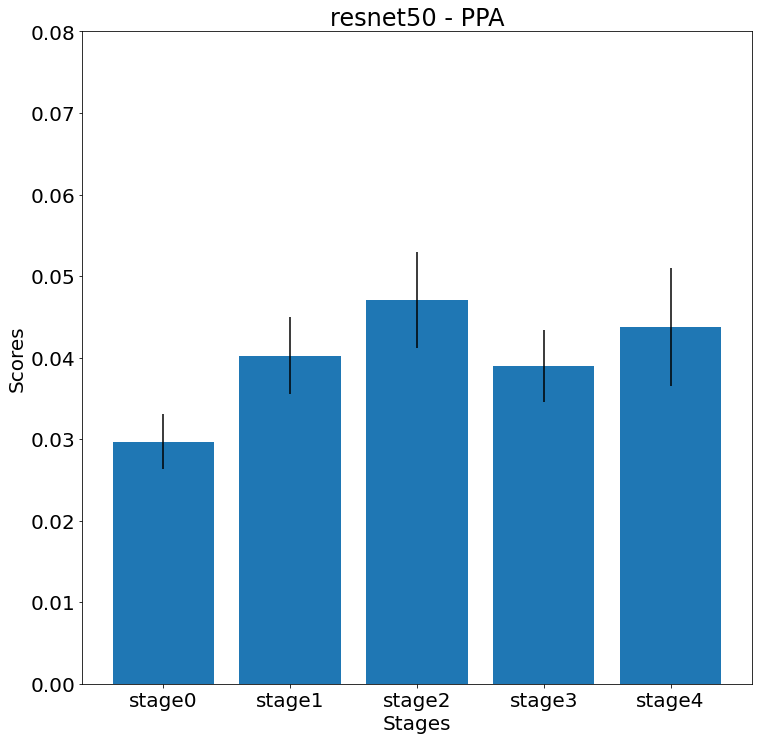

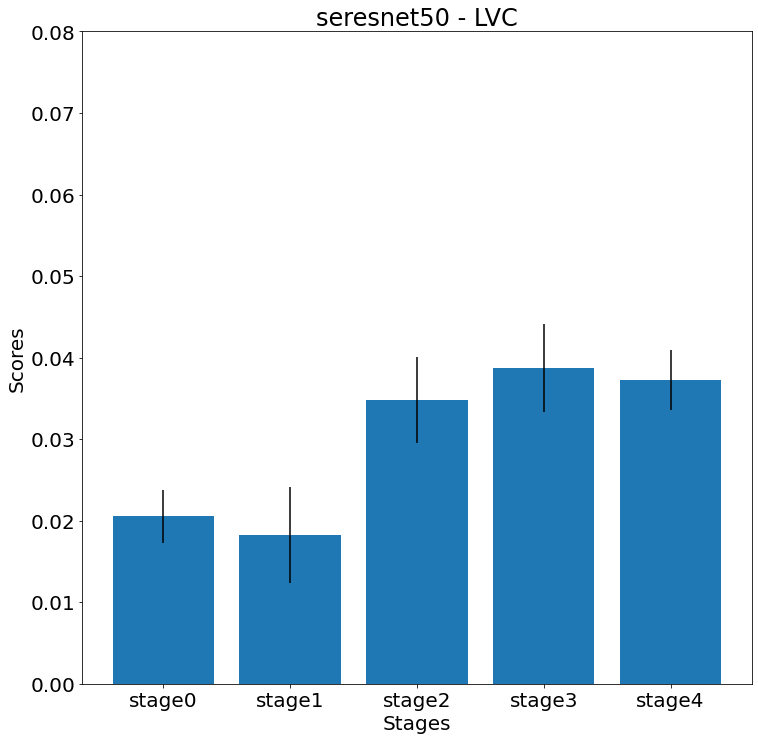

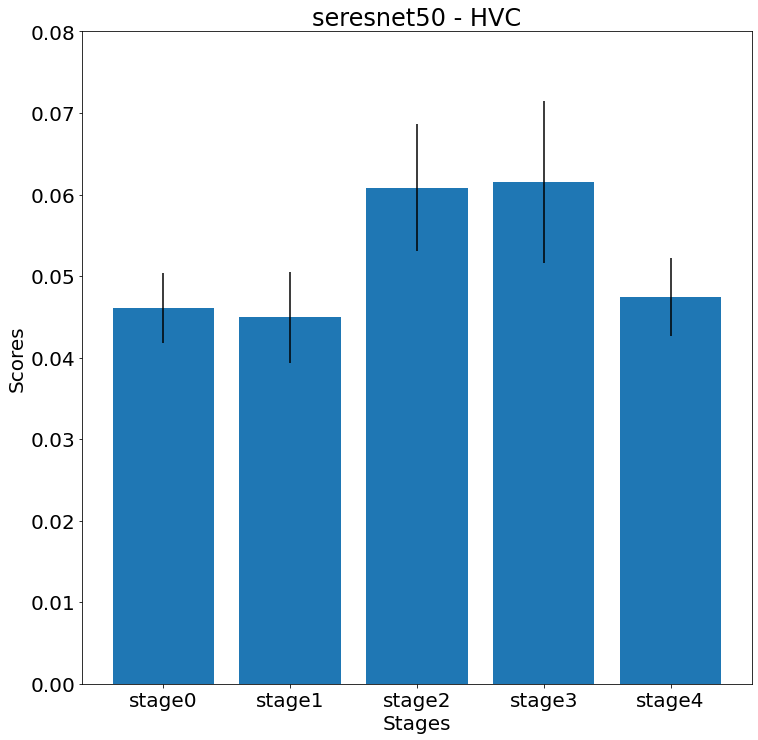

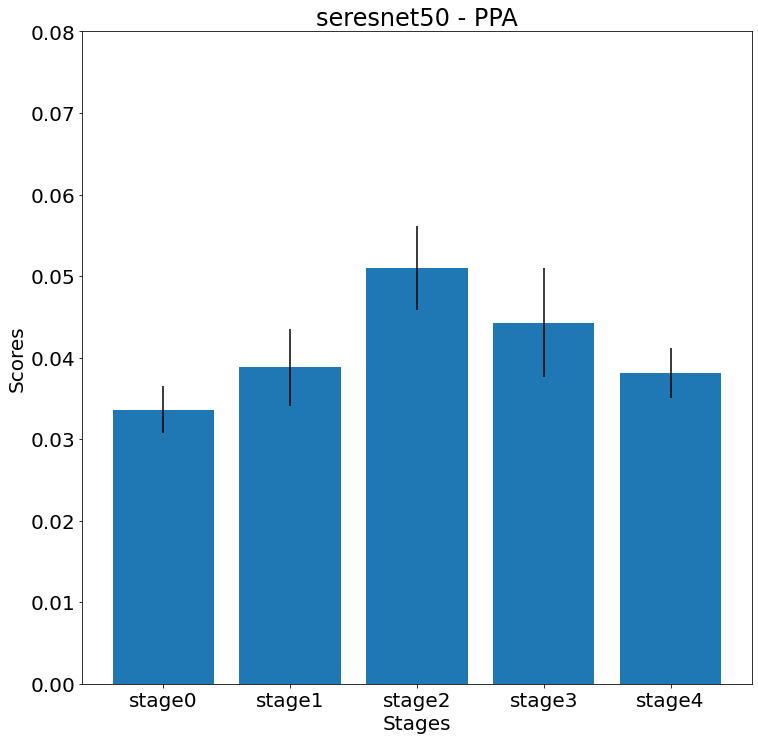

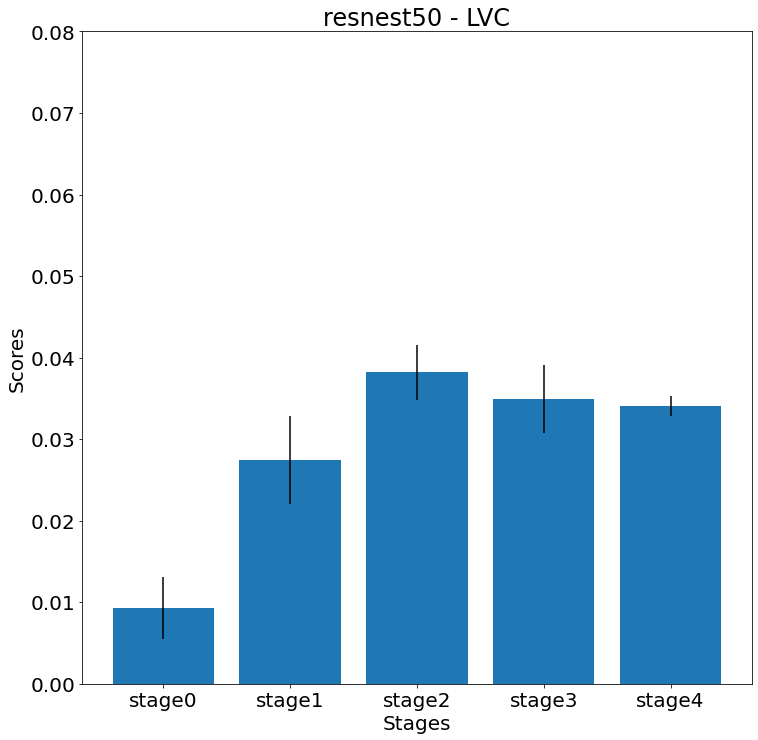

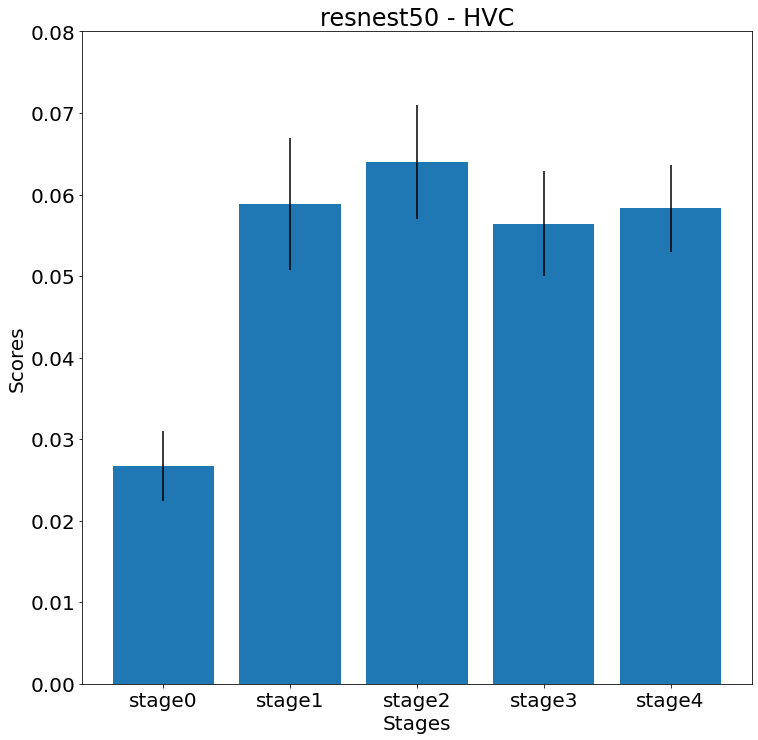

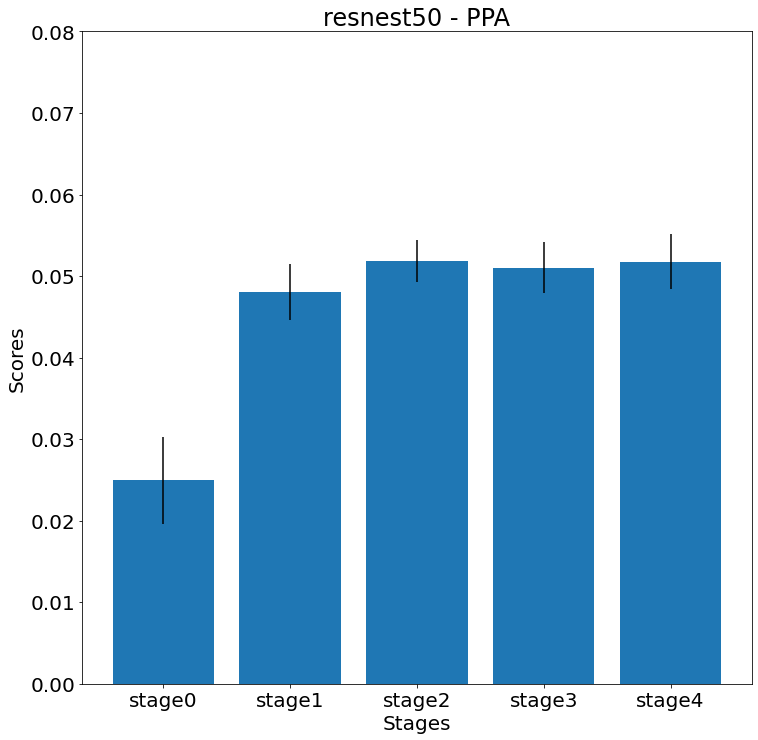

In [42]:
models = ['resnet50', 'seresnet50', 'resnest50']
stages = [0,1,2,3,4]
subjects = [0,1,2]
rois = ['LVC', 'HVC', 'PPA']

model = models[0]
roi = 'LOC'
for model in models:
    for roi in rois:
        means = []
        errs = []
        for stage in stages:
            vals = []
            for subject in subjects:
                vals.append(loaded_k[subject][model][roi][stage])
            means.append(np.mean(vals))
            # errs is the 95% confidence intervals
            # TODO check whether I should multiply by 1.96 instead of dividing
            errs.append(np.std(vals) * (1/np.sqrt(3)) * (1/1.96) )

        fig, ax = plt.subplots()
        ax.bar(stages, means, yerr=errs, label=roi, tick_label=['stage0','stage1','stage2','stage3','stage4'])
        ax.set_ylabel('Scores')
        ax.set_xlabel('Stages')
        ax.set_title(f'{model} - {roi}')
        ax.set_ylim(0,0.08)